In [1]:
import torch
from datasets import load_dataset
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import preprocessing

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = preprocessing.create_model_MLM(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [5]:
data_files = {"train": "swerick_data_long_train.pkl", "test": "swerick_data_long_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)

DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 14113
    })
    test: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 3529
    })
})


In [6]:
tokenized_datasets =preprocessing.tokenize_dataset(swerick_dataset,tokenizer)

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 14113
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 3529
    })
})

In [7]:
chunk_size = 128

In [8]:
lm_datasets = preprocessing.grouping_dataset(tokenized_datasets,chunk_size)
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4150115
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1054946
    })
})

In [9]:
with open("lm_dataset.pkl","wb") as fichier:
       pickle.dump(lm_datasets,fichier)

In [10]:
with open("lm_dataset.pkl","rb") as fichier:
       lm_datasets=pickle.load(fichier)

lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4150115
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1054946
    })
})

In [11]:
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

In [12]:
batch_size = 64
num_epochs=100
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
print(len(lm_datasets["train"]) // batch_size)
model_name = "finetuning_hugging"

trainer = preprocessing.create_trainer(model,model_name,batch_size,logging_steps,train_dataset=lm_datasets["train"],eval_dataset=lm_datasets["test"],data_collator=data_collator,tokenizer=tokenizer,num_epochs=100)

64845


/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
eval_results = trainer.evaluate()
print(eval_results)
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

  0%|          | 0/16484 [00:00<?, ?it/s]

{'eval_loss': 8.667418479919434, 'eval_runtime': 1311.0834, 'eval_samples_per_second': 804.637, 'eval_steps_per_second': 12.573}
>>> Perplexity: 5810.48


In [13]:
trainer.train()

  0%|          | 0/6484600 [00:00<?, ?it/s]

{'loss': 1.5597, 'grad_norm': 3.7292888164520264, 'learning_rate': 1.980007710575826e-05, 'epoch': 1.0}


  0%|          | 0/16484 [00:00<?, ?it/s]

{'eval_loss': 1.1449333429336548, 'eval_runtime': 1281.434, 'eval_samples_per_second': 823.254, 'eval_steps_per_second': 12.864, 'epoch': 1.0}


KeyboardInterrupt: 

In [18]:
#file_path = "finetuning_hugging.pth"
#model.save_pretrained("finetuning_trainer_total")
#tokenizer.save_pretrained("finetuning_trainer_total")

<class 'list'>
0


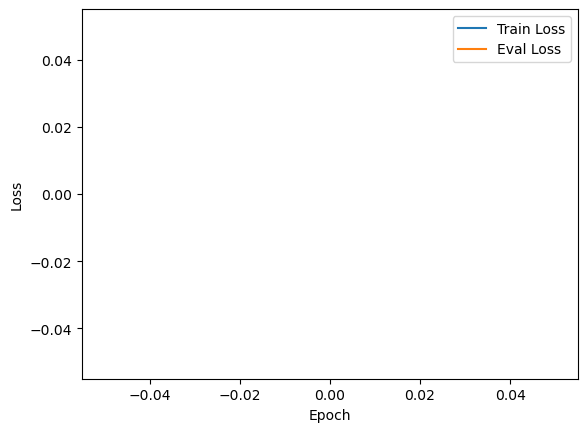

In [19]:
# Get the training and validation losses,
print(type(trainer.state.log_history))
print(len(trainer.state.log_history))
train_losses=[]
test_losses=[]
for i in range(len(trainer.state.log_history)//2):
   train_losses.append(trainer.state.log_history[2*i]["loss"])
   test_losses.append(trainer.state.log_history[2*i+1]["eva_loss"])
#eval_losses = trainer.state.log_history[\"eval_loss\"]

#print(train_losses)

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
file_name = "losses_hugging.pkl"
with open(file_name, 'wb') as f:
   # pickle.dump({'losses_train': train_losses, 'losses_test': test_losses}, f)

SyntaxError: incomplete input (1363130699.py, line 3)